# Objective: **Train AlexNet on STL-10 to classify images and visually inspect intermediate feature maps layer-by-layer, ending with correct inference on new images.**

End-to-end pipeline stes):

1. **Set experiment configuration** — *Make runs reproducible*
2. **Import required libraries** — *Enable full pipeline*
3. **Choose device and seed** — *Ensure deterministic behavior*
4. **Define STL-10 transforms** — *Match AlexNet input stats*
5. **Download and load data** — *Create train/test datasets*
6. **Create DataLoaders** — *Batch and shuffle samples*
7. **Visualize sample batch** — *Verify labels and images*
8. **Define AlexNet model** — *Build classification network*
9. **Adjust classifier head** — *Match 10 STL classes*
10. **Print model summary shapes** — *Confirm layer dimensions*
11. **Set loss and optimizer** — *Define training objective*
12. **Add learning-rate scheduler** — *Stabilize training dynamics*
13. **Run one forward pass** — *Sanity-check tensor flow*
14. **Train for one epoch** — *Validate training loop works*
15. **Track metrics and loss** — *Monitor learning progress*
16. **Evaluate on test set** — *Measure generalization performance*
17. **Save best model** — *Preserve best checkpoint*
18. **Register forward hooks** — *Capture intermediate activations*
19. **Visualize feature maps** — *Understand learned representations*
20. **Run single-image inference** — *Predict one image class*
21. **Batch inference demo** — *Infer multiple samples quickly*
22. **Export results and logs** —oceed one step at a time).


# Step 1 — Set experiment configuration (Make runs reproducible)

 **It defines hyperparameters, folders, and a few “knobs” we’ll use throughout.**

In [1]:
# Step 1: Experiment configuration (edit-friendly)

from pathlib import Path

CFG = {
    # Reproducibility
    "seed": 42,

    # Data
    "dataset_name": "STL10",
    "num_classes": 10,
    "img_size": 224,          # AlexNet expects ~224x224
    "batch_size": 64,
    "num_workers": 4,         # set 0 if you face DataLoader issues on Windows

    # Training
    "epochs": 10,
    "lr": 1e-3,
    "weight_decay": 5e-4,
    "momentum": 0.9,

    # Runtime
    "device": "cuda",         # will auto-fallback to cpu later
    "amp": True,              # mixed precision if CUDA is available

    # Output
    "work_dir": "./alexnet_stl10_runs",
    "run_name": "alexnet_stl10_v1",
}

# Create output folders
run_dir = Path(CFG["work_dir"]) / CFG["run_name"]
ckpt_dir = run_dir / "checkpoints"
viz_dir  = run_dir / "viz"
for d in [run_dir, ckpt_dir, viz_dir]:
    d.mkdir(parents=True, exist_ok=True)

print("✅ Config loaded")
print("Run dir:", run_dir.resolve())
print("Checkpoints:", ckpt_dir.resolve())
print("Visualizations:", viz_dir.resolve())
print("Key settings:",
      f"img_size={CFG['img_size']}, batch_size={CFG['batch_size']}, epochs={CFG['epochs']}, lr={CFG['lr']}")

✅ Config loaded
Run dir: C:\Users\Dr.PVVK\dna_2026\alexnet_stl10_runs\alexnet_stl10_v1
Checkpoints: C:\Users\Dr.PVVK\dna_2026\alexnet_stl10_runs\alexnet_stl10_v1\checkpoints
Visualizations: C:\Users\Dr.PVVK\dna_2026\alexnet_stl10_runs\alexnet_stl10_v1\viz
Key settings: img_size=224, batch_size=64, epochs=10, lr=0.001


# Step 2 — Import required libraries (Enable full pipeline)

In [2]:
# Step 2: Imports + quick environment check

import os, random, time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

print("✅ Imports successful")
print("PyTorch:", torch.__version__)
print("TorchVision:", __import__("torchvision").__version__)

cuda_ok = torch.cuda.is_available()
print("CUDA available:", cuda_ok)
if cuda_ok:
    print("GPU:", torch.cuda.get_device_name(0))
    print("CUDA capability:", torch.cuda.get_device_capability(0))

✅ Imports successful
PyTorch: 2.4.0+cu118
TorchVision: 0.19.0+cu118
CUDA available: True
GPU: NVIDIA GeForce GTX 1070
CUDA capability: (6, 1)


# Step 3 — Choose device and seed (Ensure deterministic behavior)

In [3]:
# Step 3: Device selection + reproducibility

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Makes results more repeatable (may slightly reduce speed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CFG["seed"])

# Resolve device safely
if CFG["device"] == "cuda" and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# If CPU, AMP should be off
use_amp = bool(CFG["amp"] and device.type == "cuda")

print("✅ Seed set to:", CFG["seed"])
print("✅ Using device:", device)
print("✅ Mixed precision (AMP):", use_amp)

# (We’ll use this later in training)
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

✅ Seed set to: 42
✅ Using device: cuda
✅ Mixed precision (AMP): True


C:\Users\Dr.PVVK\AppData\Local\Temp\ipykernel_61288\47087105.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


# Step 4 — Define STL-10 transforms (Match AlexNet input stats)

In [4]:
# Step 4: Transforms (train/test) for STL-10 -> AlexNet

from PIL import Image

# ImageNet normalization (commonly used with AlexNet-style training)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize(256),                 # upsample then crop to 224
    transforms.RandomCrop(CFG["img_size"]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(CFG["img_size"]),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Helper (we'll use it later for pretty visualization)
def denorm(img_t: torch.Tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """img_t: (3,H,W) normalized tensor -> (3,H,W) in [0,1] approx."""
    mean_t = torch.tensor(mean).view(3,1,1)
    std_t  = torch.tensor(std).view(3,1,1)
    x = img_t.detach().cpu() * std_t + mean_t
    return x.clamp(0, 1)

# Quick sanity check using a dummy 96x96 RGB image
dummy = (np.random.rand(96, 96, 3) * 255).astype(np.uint8)
dummy_pil = Image.fromarray(dummy)

x_train = train_tfms(dummy_pil)
x_test  = test_tfms(dummy_pil)

print("✅ Transforms ready")
print("Train tensor shape:", tuple(x_train.shape), "dtype:", x_train.dtype,
      "min/max:", float(x_train.min()), float(x_train.max()))
print("Test  tensor shape:", tuple(x_test.shape), "dtype:", x_test.dtype,
      "min/max:", float(x_test.min()), float(x_test.max()))

✅ Transforms ready
Train tensor shape: (3, 224, 224) dtype: torch.float32 min/max: -2.0665297508239746 2.552854299545288
Test  tensor shape: (3, 224, 224) dtype: torch.float32 min/max: -2.0665297508239746 2.5354249477386475


# Step 5 — Download and load data (Create train/test datasets)

In [5]:
# Step 5: Download + load STL-10 datasets

data_root = run_dir / "data"
data_root.mkdir(parents=True, exist_ok=True)

train_ds = datasets.STL10(
    root=str(data_root),
    split="train",
    download=True,
    transform=train_tfms
)

test_ds = datasets.STL10(
    root=str(data_root),
    split="test",
    download=True,
    transform=test_tfms
)

print("✅ STL-10 loaded")
print("Data root:", data_root.resolve())
print("Train size:", len(train_ds))
print("Test  size:", len(test_ds))

# Class names
try:
    print("Classes:", train_ds.classes)
except Exception as e:
    print("Could not read classes:", e)

# Check one sample
x0, y0 = train_ds[0]
print("\nSample check:")
print("x0 shape:", tuple(x0.shape), "dtype:", x0.dtype)
print("y0:", int(y0), "->", train_ds.classes[int(y0)] if hasattr(train_ds, "classes") else "class")
print("x0 min/max:", float(x0.min()), float(x0.max()))

Files already downloaded and verified
Files already downloaded and verified
✅ STL-10 loaded
Data root: C:\Users\Dr.PVVK\dna_2026\alexnet_stl10_runs\alexnet_stl10_v1\data
Train size: 5000
Test  size: 8000
Classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

Sample check:
x0 shape: (3, 224, 224) dtype: torch.float32
y0: 1 -> bird
x0 min/max: -2.0494048595428467 2.3760502338409424


# Step 6 — Create DataLoaders (Batch and shuffle samples)

In [6]:
# Step 6: DataLoaders (batching + shuffling)

# Windows often works best with num_workers=0
nw = 0 if os.name == "nt" else int(CFG["num_workers"])
pin = (device.type == "cuda")

train_loader = DataLoader(
    train_ds,
    batch_size=CFG["batch_size"],
    shuffle=True,
    num_workers=nw,
    pin_memory=pin,
    drop_last=True,
    persistent_workers=(nw > 0),
    prefetch_factor=2 if nw > 0 else None,
)

test_loader = DataLoader(
    test_ds,
    batch_size=CFG["batch_size"],
    shuffle=False,
    num_workers=nw,
    pin_memory=pin,
    drop_last=False,
    persistent_workers=(nw > 0),
    prefetch_factor=2 if nw > 0 else None,
)

print("✅ DataLoaders ready")
print("num_workers:", nw, "| pin_memory:", pin)
print("train batches:", len(train_loader), "| test batches:", len(test_loader))

# Sanity-check a single batch
xb, yb = next(iter(train_loader))
print("\nBatch check:")
print("xb:", tuple(xb.shape), xb.dtype)
print("yb:", tuple(yb.shape), yb.dtype)
print("labels (first 10):", yb[:10].tolist())

✅ DataLoaders ready
num_workers: 0 | pin_memory: True
train batches: 78 | test batches: 125

Batch check:
xb: (64, 3, 224, 224) torch.float32
yb: (64,) torch.int64
labels (first 10): [4, 8, 1, 4, 9, 8, 0, 0, 5, 8]


# Step 7 — Visualize sample batch (Verify labels and images)

Displayed labels: ['dog', 'monkey', 'monkey', 'car', 'dog', 'car', 'ship', 'cat', 'monkey', 'airplane', 'car', 'dog', 'ship', 'deer', 'car', 'monkey']


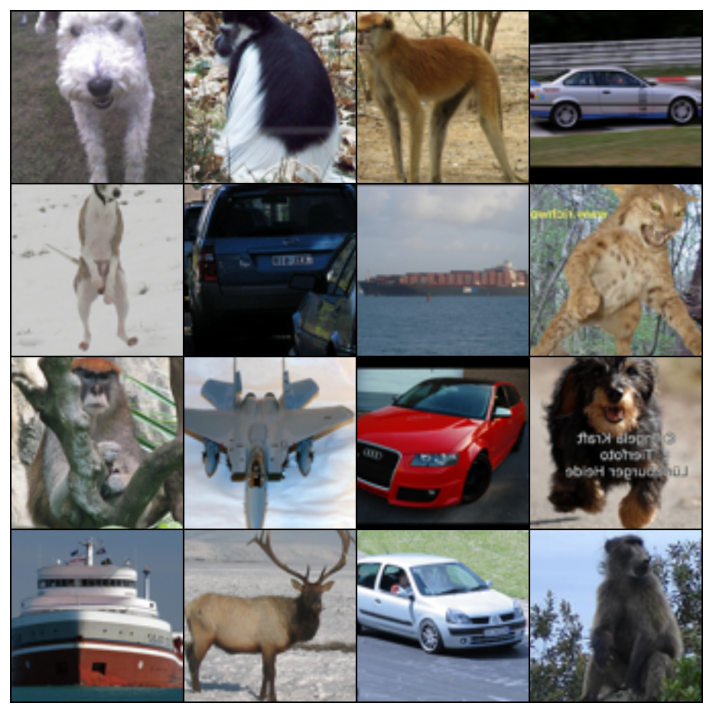

In [7]:
# Step 7: Visualize a training batch (denormalized)

# Fetch one batch
xb, yb = next(iter(train_loader))

# Take first 16 images for a clean grid
n_show = 16
imgs = torch.stack([denorm(xb[i]) for i in range(n_show)], dim=0)   # (N,3,H,W) in [0,1]
grid = make_grid(imgs, nrow=4)

plt.figure(figsize=(9, 9))
plt.imshow(grid.permute(1, 2, 0))  # CHW -> HWC
plt.axis("off")

# Print labels under the plot (simple + readable)
label_names = [train_ds.classes[int(y)] for y in yb[:n_show]]
print("Displayed labels:", label_names)

plt.show()

# Step 8 — Define AlexNet model (Build classification network)

In [8]:
# Step 8: AlexNet definition (near-original)

class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000):
        super().__init__()

        self.features = nn.Sequential(
            # Conv1
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv2
            nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv3-5
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Keeps the classic AlexNet classifier input (256*6*6) even if input size changes a bit
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)   # (N, 256*6*6)
        x = self.classifier(x)
        return x


# Quick sanity check (forward pass with dummy input)
dummy = torch.randn(2, 3, CFG["img_size"], CFG["img_size"])
model_tmp = AlexNet(num_classes=1000)
out = model_tmp(dummy)

print("✅ AlexNet class defined")
print("Dummy input :", tuple(dummy.shape))
print("Dummy output:", tuple(out.shape))  # should be (2, 1000)

✅ AlexNet class defined
Dummy input : (2, 3, 224, 224)
Dummy output: (2, 1000)


In [9]:
# Step 8.5: Architecture table (shapes + params + hyperparams + activation)

import pandas as pd
import torch.nn as nn

# Instantiate just for summary (does NOT affect training later)
model_arch = AlexNet(num_classes=CFG["num_classes"]).to("cpu").eval()

# --- capture leaf-module I/O shapes in forward order ---
records = []
handles = []

def is_leaf(m: nn.Module):
    return len(list(m.children())) == 0

def hook_fn(name):
    def _hook(m, inp, out):
        # inp is a tuple; first element is tensor
        in_shape = tuple(inp[0].shape) if isinstance(inp, (tuple, list)) and hasattr(inp[0], "shape") else None
        out_shape = tuple(out.shape) if hasattr(out, "shape") else None

        # count params
        params = sum(p.numel() for p in m.parameters() if p.requires_grad)

        # default fields
        rec = {
            "name": name,
            "type": m.__class__.__name__,
            "in_shape": in_shape,
            "out_shape": out_shape,
            "filters/units": "",
            "kernel": "",
            "stride": "",
            "padding": "",
            "activation": "",
            "trainable_params": params,
        }

        # fill layer-specific hyperparams
        if isinstance(m, nn.Conv2d):
            rec["filters/units"] = m.out_channels
            rec["kernel"] = tuple(m.kernel_size)
            rec["stride"] = tuple(m.stride)
            rec["padding"] = tuple(m.padding)

        elif isinstance(m, nn.Linear):
            rec["filters/units"] = m.out_features

        elif isinstance(m, nn.MaxPool2d):
            rec["kernel"] = m.kernel_size
            rec["stride"] = m.stride
            rec["padding"] = m.padding

        elif isinstance(m, nn.AdaptiveAvgPool2d):
            rec["kernel"] = f"out={m.output_size}"

        elif isinstance(m, nn.Dropout):
            rec["kernel"] = f"p={m.p}"

        records.append(rec)
    return _hook

# register hooks on all leaf modules
for name, m in model_arch.named_modules():
    if is_leaf(m):
        handles.append(m.register_forward_hook(hook_fn(name)))

# forward pass with dummy input to populate shapes
x = torch.zeros(1, 3, CFG["img_size"], CFG["img_size"])
with torch.no_grad():
    _ = model_arch(x)

# remove hooks
for h in handles:
    h.remove()

# --- merge ReLU activations into previous layer row ---
merged = []
for r in records:
    if r["type"] == "ReLU":
        if merged:
            merged[-1]["activation"] = "ReLU"
        continue
    merged.append(r)

# --- insert explicit Flatten row (since flatten is in forward, not a module) ---
# Find avgpool row and use its output shape to compute flatten size
flat_inserted = []
for i, r in enumerate(merged):
    flat_inserted.append(r)
    if r["type"] == "AdaptiveAvgPool2d":
        out_shape = r["out_shape"]  # (N,C,H,W)
        if out_shape and len(out_shape) == 4:
            n, c, h, w = out_shape
            flat_inserted.append({
                "name": "flatten",
                "type": "Flatten",
                "in_shape": out_shape,
                "out_shape": (n, c*h*w),
                "filters/units": "",
                "kernel": "",
                "stride": "",
                "padding": "",
                "activation": "",
                "trainable_params": 0,
            })

df = pd.DataFrame(flat_inserted)

# Clean up shapes to show CxHxW (drop batch dim)
def shape_chw(s):
    if s is None:
        return ""
    s = tuple(s)
    if len(s) == 4:
        return f"{s[1]}x{s[2]}x{s[3]}"
    if len(s) == 2:
        return str(s[1])
    return str(s)

df["in"]  = df["in_shape"].apply(shape_chw)
df["out"] = df["out_shape"].apply(shape_chw)

# reorder / present
show = df[[
    "name", "type", "in", "out",
    "filters/units", "kernel", "stride", "padding",
    "activation", "trainable_params"
]].copy()

# add layer index
show.insert(0, "#", range(1, len(show) + 1))

total_params = int(show["trainable_params"].sum())

print("✅ AlexNet Architecture Summary")
print(f"Input: 3x{CFG['img_size']}x{CFG['img_size']} | Classes: {CFG['num_classes']}")
print(f"Total trainable params: {total_params:,}")

# display table
show

✅ AlexNet Architecture Summary
Input: 3x224x224 | Classes: 10
Total trainable params: 57,044,810


,#,name,type,in,out,filters/units,kernel,stride,padding,activation,trainable_params
0,1,features.0,Conv2d,3x224x224,64x55x55,64,"(11, 11)","(4, 4)","(2, 2)",ReLU,23296
1,2,features.2,MaxPool2d,64x55x55,64x27x27,,3,2,0,,0
2,3,features.3,Conv2d,64x27x27,192x27x27,192,"(5, 5)","(1, 1)","(2, 2)",ReLU,307392
3,4,features.5,MaxPool2d,192x27x27,192x13x13,,3,2,0,,0
4,5,features.6,Conv2d,192x13x13,384x13x13,384,"(3, 3)","(1, 1)","(1, 1)",ReLU,663936
5,6,features.8,Conv2d,384x13x13,256x13x13,256,"(3, 3)","(1, 1)","(1, 1)",ReLU,884992
6,7,features.10,Conv2d,256x13x13,256x13x13,256,"(3, 3)","(1, 1)","(1, 1)",ReLU,590080
7,8,features.12,MaxPool2d,256x13x13,256x6x6,,3,2,0,,0
8,9,avgpool,AdaptiveAvgPool2d,256x6x6,256x6x6,,"out=(6, 6)",,,,0
9,10,flatten,Flatten,256x6x6,9216,,,,,,0


# Step 9 — Instantiate model for STL-10 (Match 10 classes)

In [10]:
# Step 9: Create AlexNet(num_classes=10), move to device, sanity-check forward

model = AlexNet(num_classes=CFG["num_classes"]).to(device)

# Verify final layer matches classes
final_linear = None
for m in reversed(list(model.classifier)):
    if isinstance(m, nn.Linear):
        final_linear = m
        break

print("✅ Model instantiated")
print("Device:", next(model.parameters()).device)
print("Final classifier layer out_features:", final_linear.out_features if final_linear else "N/A")
assert final_linear is not None and final_linear.out_features == CFG["num_classes"], "Classifier head mismatch!"

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

# Forward-pass sanity check on one real batch
model.eval()
xb, yb = next(iter(train_loader))
xb = xb.to(device, non_blocking=True)
yb = yb.to(device, non_blocking=True)

with torch.no_grad():
    logits = model(xb)

print("Batch x:", tuple(xb.shape), "| logits:", tuple(logits.shape), "| y:", tuple(yb.shape))
print("Logits stats -> min/max/mean:",
      float(logits.min().detach().cpu()),
      float(logits.max().detach().cpu()),
      float(logits.mean().detach().cpu()))

✅ Model instantiated
Device: cuda:0
Final classifier layer out_features: 10
Trainable parameters: 57,044,810
Batch x: (64, 3, 224, 224) | logits: (64, 10) | y: (64,)
Logits stats -> min/max/mean: -0.025602450594305992 0.023846391588449478 0.003083278425037861


# Step 10 — Print model shape flow (Confirm layer dimensions)

In [11]:
# Step 10: Shape flow through AlexNet (major checkpoints)

model.eval()
xb, yb = next(iter(train_loader))
x = xb[:2].to(device)  # just 2 samples to keep output tidy

print("Input:", tuple(x.shape))

with torch.no_grad():
    # features is a Sequential: we can step through it
    for i, layer in enumerate(model.features):
        x = layer(x)
        # print only after conv/pool (and keep it readable)
        if isinstance(layer, (nn.Conv2d, nn.MaxPool2d)):
            print(f"features[{i:02d}] {layer.__class__.__name__:<10} -> {tuple(x.shape)}")

    x = model.avgpool(x)
    print("avgpool (AdaptiveAvgPool2d) ->", tuple(x.shape))

    x = torch.flatten(x, 1)
    print("flatten ->", tuple(x.shape))

    # classifier flow
    for i, layer in enumerate(model.classifier):
        x = layer(x)
        if isinstance(layer, (nn.Linear, nn.Dropout)):
            print(f"classifier[{i:02d}] {layer.__class__.__name__:<10} -> {tuple(x.shape)}")

print("✅ Shape flow printed")

Input: (2, 3, 224, 224)
features[00] Conv2d     -> (2, 64, 55, 55)
features[02] MaxPool2d  -> (2, 64, 27, 27)
features[03] Conv2d     -> (2, 192, 27, 27)
features[05] MaxPool2d  -> (2, 192, 13, 13)
features[06] Conv2d     -> (2, 384, 13, 13)
features[08] Conv2d     -> (2, 256, 13, 13)
features[10] Conv2d     -> (2, 256, 13, 13)
features[12] MaxPool2d  -> (2, 256, 6, 6)
avgpool (AdaptiveAvgPool2d) -> (2, 256, 6, 6)
flatten -> (2, 9216)
classifier[00] Dropout    -> (2, 9216)
classifier[01] Linear     -> (2, 4096)
classifier[03] Dropout    -> (2, 4096)
classifier[04] Linear     -> (2, 4096)
classifier[06] Linear     -> (2, 10)
✅ Shape flow printed


# Step 11 — Set loss and optimizer (Define training objective)

In [12]:
# Step 11: Loss + optimizer

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(
    model.parameters(),
    lr=CFG["lr"],
    momentum=CFG["momentum"],
    weight_decay=CFG["weight_decay"]
)

print("✅ Loss and optimizer set")
print("Loss: CrossEntropyLoss")
print(f"Optimizer: SGD(lr={CFG['lr']}, momentum={CFG['momentum']}, weight_decay={CFG['weight_decay']})")

✅ Loss and optimizer set
Loss: CrossEntropyLoss
Optimizer: SGD(lr=0.001, momentum=0.9, weight_decay=0.0005)


# Step 12 — Add learning-rate scheduler (Stabilize training dynamics)

In [13]:
# Step 12: Learning-rate scheduler

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,   # drop LR every 5 epochs
    gamma=0.1      # LR = LR * 0.1
)

print("✅ Scheduler set: StepLR(step_size=5, gamma=0.1)")
print("Initial LR:", optimizer.param_groups[0]["lr"])

✅ Scheduler set: StepLR(step_size=5, gamma=0.1)
Initial LR: 0.001


# Step 13 — Run one forward pass (Sanity-check tensor flow)

In [14]:
# Step 13: Single forward pass sanity-check (no training update)

model.train()  # training mode (dropout ON) to reflect real training behavior

xb, yb = next(iter(train_loader))
xb = xb.to(device, non_blocking=True)
yb = yb.to(device, non_blocking=True)

optimizer.zero_grad(set_to_none=True)

with torch.cuda.amp.autocast(enabled=use_amp):
    logits = model(xb)
    loss = criterion(logits, yb)

# Basic checks
loss_val = float(loss.detach().cpu())
is_finite = torch.isfinite(loss).item()

pred = logits.argmax(dim=1)
acc = (pred == yb).float().mean().item()

print("✅ Forward pass OK")
print("logits:", tuple(logits.shape))
print("loss:", loss_val, "| finite:", bool(is_finite))
print("batch accuracy:", round(acc * 100, 2), "%")

# Show a few predictions
k = 10
print("\nFirst", k, "labels/preds:")
for i in range(k):
    yi = int(yb[i].detach().cpu())
    pi = int(pred[i].detach().cpu())
    print(f"{i:02d}: true={train_ds.classes[yi]:>10s} | pred={train_ds.classes[pi]:>10s}")

✅ Forward pass OK
logits: (64, 10)
loss: 2.301605224609375 | finite: True
batch accuracy: 14.06 %

First 10 labels/preds:
00: true=     horse | pred=  airplane
01: true=       car | pred=  airplane
02: true=       cat | pred=  airplane
03: true=     horse | pred=  airplane
04: true=       car | pred=     truck
05: true=       dog | pred=  airplane
06: true=    monkey | pred=  airplane
07: true=  airplane | pred=  airplane
08: true=       dog | pred=  airplane
09: true=       cat | pred=  airplane


C:\Users\Dr.PVVK\AppData\Local\Temp\ipykernel_61288\3116686085.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


# Step 14 — Train for one epoch (Validate training loop works)

In [15]:
import time
import torch
import torch.nn as nn

# -------------------
# 0) Choose epochs
# -------------------
EPOCHS = 30   # <- set 10 or 20

# (Optional but recommended) Make SGD a bit more effective for AlexNet-from-scratch
# Comment these 2 lines if you don't want to change anything.
for g in optimizer.param_groups:
    g["lr"] = 0.01
    g["weight_decay"] = 1e-4

print("Training epochs:", EPOCHS)
print("LR:", optimizer.param_groups[0]["lr"], "| weight_decay:", optimizer.param_groups[0]["weight_decay"])

# -------------------
# 1) Utilities
# -------------------
def save_checkpoint(path, **payload):
    torch.save(payload, str(path))
    print(f"✅ Saved: {path}")

def train_one_epoch(model, loader, optimizer, criterion, device, use_amp=False, scaler=None, log_every=20):
    model.train()
    if scaler is None:
        scaler = torch.cuda.amp.GradScaler(enabled=False)

    t0 = time.time()
    total_loss, total_correct, total_seen = 0.0, 0, 0

    for step, (xb, yb) in enumerate(loader, start=1):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(xb)
            loss = criterion(logits, yb)

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        bs = xb.size(0)
        total_seen += bs
        total_loss += loss.detach().item() * bs
        total_correct += (logits.argmax(1) == yb).sum().item()

        if step == 1 or step % log_every == 0 or step == len(loader):
            avg_loss = total_loss / total_seen
            avg_acc = 100.0 * total_correct / total_seen
            lr = optimizer.param_groups[0]["lr"]
            print(f"  step {step:4d}/{len(loader)} | lr {lr:.5f} | loss {avg_loss:.4f} | acc {avg_acc:.2f}%")

    return (total_loss / total_seen), (100.0 * total_correct / total_seen), (time.time() - t0)

@torch.no_grad()
def evaluate(model, loader, criterion, device, use_amp=False):
    model.eval()
    t0 = time.time()
    total_loss, total_correct, total_seen = 0.0, 0, 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(xb)
            loss = criterion(logits, yb)

        bs = xb.size(0)
        total_seen += bs
        total_loss += loss.detach().item() * bs
        total_correct += (logits.argmax(1) == yb).sum().item()

    return (total_loss / total_seen), (100.0 * total_correct / total_seen), (time.time() - t0)

# -------------------
# 2) History + best tracker
# -------------------
if "history" not in globals():
    history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": [], "lr": []}

if "best_test_acc" not in globals():
    best_test_acc = -1.0

criterion = criterion  # already defined in your steps
scaler = scaler        # already defined in Step 3
use_amp = use_amp      # already defined in Step 3

# -------------------
# 3) Main training loop
# -------------------
for epoch in range(1, EPOCHS + 1):
    print(f"\n===== Epoch {epoch}/{EPOCHS} =====")

    tr_loss, tr_acc, tr_time = train_one_epoch(
        model, train_loader, optimizer, criterion, device,
        use_amp=use_amp, scaler=scaler, log_every=20
    )

    te_loss, te_acc, te_time = evaluate(
        model, test_loader, criterion, device,
        use_amp=use_amp
    )

    # Scheduler step (per-epoch)
    if "scheduler" in globals() and scheduler is not None:
        scheduler.step()

    lr_now = optimizer.param_groups[0]["lr"]

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["test_loss"].append(te_loss)
    history["test_acc"].append(te_acc)
    history["lr"].append(lr_now)

    print(f"Epoch {epoch:02d} | train: loss {tr_loss:.4f}, acc {tr_acc:.2f}% ({tr_time:.1f}s) "
          f"| test: loss {te_loss:.4f}, acc {te_acc:.2f}% ({te_time:.1f}s) | lr {lr_now:.5f}")

    # ---- checkpointing ----
    ckpt_latest = ckpt_dir / "alexnet_stl10_latest.pt"
    save_checkpoint(
        ckpt_latest,
        epoch=epoch,
        cfg=CFG,
        model_state=model.state_dict(),
        optimizer_state=optimizer.state_dict(),
        scheduler_state=scheduler.state_dict() if ("scheduler" in globals() and scheduler is not None) else None,
        best_test_acc=best_test_acc,
        history=history
    )

    if te_acc > best_test_acc:
        best_test_acc = float(te_acc)
        ckpt_best = ckpt_dir / "alexnet_stl10_best.pt"
        save_checkpoint(
            ckpt_best,
            epoch=epoch,
            cfg=CFG,
            model_state=model.state_dict(),
            optimizer_state=optimizer.state_dict(),
            scheduler_state=scheduler.state_dict() if ("scheduler" in globals() and scheduler is not None) else None,
            best_test_acc=best_test_acc,
            history=history
        )
        print(f"🏆 New best test acc: {best_test_acc:.2f}%")

print("\n✅ Training complete")
print("Best test acc:", best_test_acc)

C:\Users\Dr.PVVK\AppData\Local\Temp\ipykernel_61288\1685190867.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Training epochs: 30
LR: 0.01 | weight_decay: 0.0001

===== Epoch 1/30 =====
  step    1/78 | lr 0.01000 | loss 2.3029 | acc 6.25%
  step   20/78 | lr 0.01000 | loss 2.3024 | acc 10.00%
  step   40/78 | lr 0.01000 | loss 2.3021 | acc 10.74%
  step   60/78 | lr 0.01000 | loss 2.3021 | acc 10.49%
  step   78/78 | lr 0.01000 | loss 2.3017 | acc 10.74%


C:\Users\Dr.PVVK\AppData\Local\Temp\ipykernel_61288\1685190867.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 01 | train: loss 2.3017, acc 10.74% (18.9s) | test: loss 2.2962, acc 10.28% (41.8s) | lr 0.01000
✅ Saved: alexnet_stl10_runs\alexnet_stl10_v1\checkpoints\alexnet_stl10_latest.pt
✅ Saved: alexnet_stl10_runs\alexnet_stl10_v1\checkpoints\alexnet_stl10_best.pt
🏆 New best test acc: 10.28%

===== Epoch 2/30 =====
  step    1/78 | lr 0.01000 | loss 2.2955 | acc 6.25%
  step   20/78 | lr 0.01000 | loss 2.2947 | acc 9.45%
  step   40/78 | lr 0.01000 | loss 2.2866 | acc 10.90%
  step   60/78 | lr 0.01000 | loss 2.2495 | acc 13.23%
  step   78/78 | lr 0.01000 | loss 2.2211 | acc 14.74%
Epoch 02 | train: loss 2.2211, acc 14.74% (20.1s) | test: loss 2.0633, acc 20.50% (42.0s) | lr 0.01000
✅ Saved: alexnet_stl10_runs\alexnet_stl10_v1\checkpoints\alexnet_stl10_latest.pt
✅ Saved: alexnet_stl10_runs\alexnet_stl10_v1\checkpoints\alexnet_stl10_best.pt
🏆 New best test acc: 20.50%

===== Epoch 3/30 =====
  step    1/78 | lr 0.01000 | loss 2.1917 | acc 17.19%
  step   20/78 | lr 0.01000 | loss 2.0543 

# Plot training curves (loss + accuracy)

Lengths: train_loss 30 test_loss 30 train_acc 30 test_acc 30 lr 30


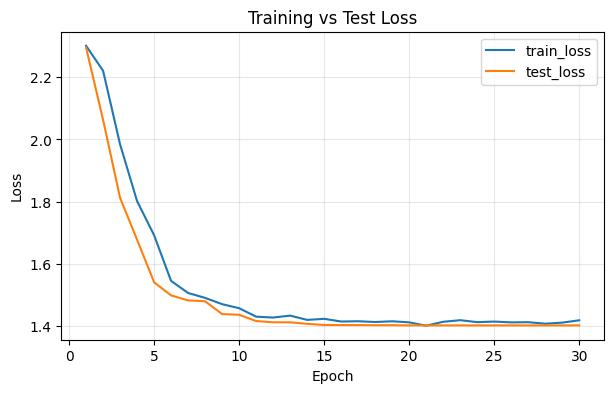

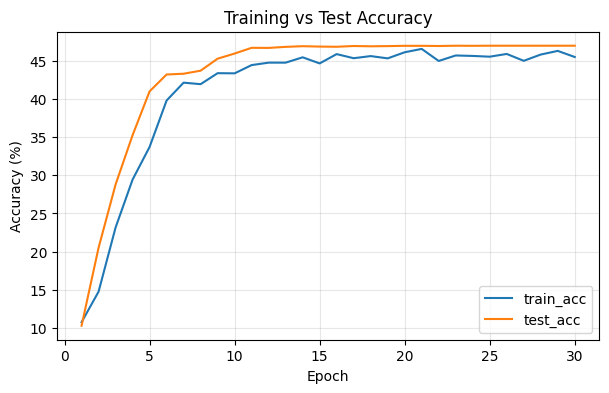

In [16]:
# Fix plotting when train/test history lengths differ

import matplotlib.pyplot as plt

def _len(x): 
    return len(x) if x is not None else 0

print("Lengths:",
      "train_loss", _len(history.get("train_loss")),
      "test_loss",  _len(history.get("test_loss")),
      "train_acc",  _len(history.get("train_acc")),
      "test_acc",   _len(history.get("test_acc")),
      "lr",         _len(history.get("lr")))

# Plot LOSS (each against its own epoch index)
plt.figure(figsize=(7,4))
if _len(history.get("train_loss")):
    x_tr = range(1, _len(history["train_loss"]) + 1)
    plt.plot(list(x_tr), history["train_loss"], label="train_loss")
if _len(history.get("test_loss")):
    x_te = range(1, _len(history["test_loss"]) + 1)
    plt.plot(list(x_te), history["test_loss"], label="test_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot ACCURACY (each against its own epoch index)
plt.figure(figsize=(7,4))
if _len(history.get("train_acc")):
    x_tr = range(1, _len(history["train_acc"]) + 1)
    plt.plot(list(x_tr), history["train_acc"], label="train_acc")
if _len(history.get("test_acc")):
    x_te = range(1, _len(history["test_acc"]) + 1)
    plt.plot(list(x_te), history["test_acc"], label="test_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Test Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
# B) Load best checkpoint and evaluate on test set

import torch
import numpy as np

best_path = ckpt_dir / "alexnet_stl10_best.pt"
assert best_path.exists(), f"Best checkpoint not found at: {best_path}"

ckpt = torch.load(str(best_path), map_location="cpu")
model.load_state_dict(ckpt["model_state"])
model.to(device).eval()

print("✅ Loaded best model checkpoint")
print("Checkpoint epoch:", ckpt.get("epoch", "N/A"))
print("Checkpoint best_test_acc:", ckpt.get("best_test_acc", "N/A"))

@torch.no_grad()
def eval_collect_preds(model, loader, device, use_amp=False):
    all_preds, all_y = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(xb)
        preds = logits.argmax(dim=1).detach().cpu().numpy()
        all_preds.append(preds)
        all_y.append(yb.numpy())
    return np.concatenate(all_y), np.concatenate(all_preds)

y_true, y_pred = eval_collect_preds(model, test_loader, device=device, use_amp=use_amp)

test_acc_best = (y_true == y_pred).mean() * 100
print(f"✅ Best-model test accuracy (recomputed): {test_acc_best:.2f}%")

C:\Users\Dr.PVVK\AppData\Local\Temp\ipykernel_61288\137980878.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(str(best_path), map_location="cpu")


✅ Loaded best model checkpoint
Checkpoint epoch: 23
Checkpoint best_test_acc: 47.0125


C:\Users\Dr.PVVK\AppData\Local\Temp\ipykernel_61288\137980878.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


✅ Best-model test accuracy (recomputed): 47.01%


In [18]:
# C) Metrics + Confusion Matrix

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)

print("\n=== Test Metrics (Best Model) ===")
print(f"Accuracy : {acc*100:.2f}%")
print(f"Precision (macro): {prec*100:.2f}%")
print(f"Recall    (macro): {rec*100:.2f}%")
print(f"F1-score  (macro): {f1*100:.2f}%")

# Optional: full per-class report
class_names = train_ds.classes if hasattr(train_ds, "classes") else [str(i) for i in range(CFG["num_classes"])]
print("\n=== Per-class Report ===")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


=== Test Metrics (Best Model) ===
Accuracy : 47.01%
Precision (macro): 46.19%
Recall    (macro): 47.01%
F1-score  (macro): 45.00%

=== Per-class Report ===
              precision    recall  f1-score   support

    airplane       0.67      0.70      0.68       800
        bird       0.43      0.24      0.31       800
         car       0.61      0.77      0.68       800
         cat       0.35      0.27      0.30       800
        deer       0.41      0.54      0.46       800
         dog       0.27      0.06      0.10       800
       horse       0.47      0.53      0.50       800
      monkey       0.31      0.57      0.40       800
        ship       0.61      0.58      0.60       800
       truck       0.51      0.44      0.47       800

    accuracy                           0.47      8000
   macro avg       0.46      0.47      0.45      8000
weighted avg       0.46      0.47      0.45      8000



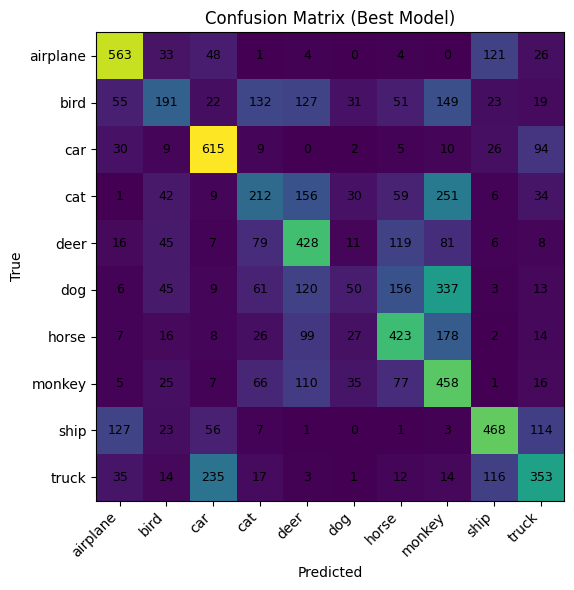

In [19]:
# D) Confusion matrix plot (with values)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=list(range(CFG["num_classes"])))

plt.figure(figsize=(7,6))
plt.imshow(cm)
plt.title("Confusion Matrix (Best Model)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(CFG["num_classes"]), class_names, rotation=45, ha="right")
plt.yticks(range(CFG["num_classes"]), class_names)

# write values on cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=9)

plt.tight_layout()
plt.show()

In [20]:
# Step 18: Forward hooks to capture intermediate activations

import torch
import torch.nn as nn

# 1) Choose which layers to capture
CAPTURE = {
    "conv1": model.features[0],
    "pool1": model.features[2],
    "conv2": model.features[3],
    "pool2": model.features[5],
    "conv3": model.features[6],
    "conv4": model.features[8],
    "conv5": model.features[10],
    "pool3": model.features[12],
}

acts = {}
handles = []

def make_hook(name):
    def _hook(module, inp, out):
        # store as CPU tensor for easy visualization later
        acts[name] = out.detach().cpu()
    return _hook

# 2) Register hooks
for name, layer in CAPTURE.items():
    handles.append(layer.register_forward_hook(make_hook(name)))

print("✅ Hooks registered for:", list(CAPTURE.keys()))

# 3) Pick one test image (change idx to explore)
idx = 0  # try 0, 10, 100, etc.
x_img, y_lbl = test_ds[idx]               # x_img is normalized tensor (3,224,224)
x_in = x_img.unsqueeze(0).to(device)      # (1,3,224,224)

model.eval()
with torch.no_grad(), torch.cuda.amp.autocast(enabled=use_amp):
    logits = model(x_in)
    pred = int(logits.argmax(dim=1).detach().cpu())

print(f"✅ Forward pass done for test_ds[{idx}]")
print("True label:", int(y_lbl), "->", train_ds.classes[int(y_lbl)])
print("Pred label:", pred, "->", train_ds.classes[pred])

# 4) Print captured activation shapes
for k in acts:
    print(f"{k:5s} :", tuple(acts[k].shape))

# NOTE: Keep `handles` until you're done visualizing.
# We'll remove hooks after Step 19 using:
# for h in handles: h.remove()


✅ Hooks registered for: ['conv1', 'pool1', 'conv2', 'pool2', 'conv3', 'conv4', 'conv5', 'pool3']
✅ Forward pass done for test_ds[0]
True label: 6 -> horse
Pred label: 6 -> horse
conv1 : (1, 64, 55, 55)
pool1 : (1, 64, 27, 27)
conv2 : (1, 192, 27, 27)
pool2 : (1, 192, 13, 13)
conv3 : (1, 384, 13, 13)
conv4 : (1, 256, 13, 13)
conv5 : (1, 256, 13, 13)
pool3 : (1, 256, 6, 6)


C:\Users\Dr.PVVK\AppData\Local\Temp\ipykernel_61288\1257191928.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=use_amp):


# Step 19 — Visualize feature maps (Understand learned representations)

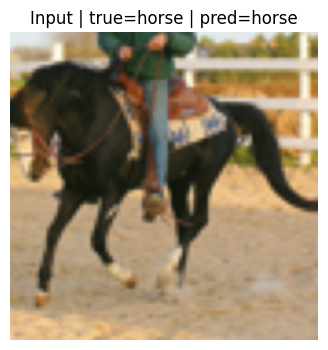

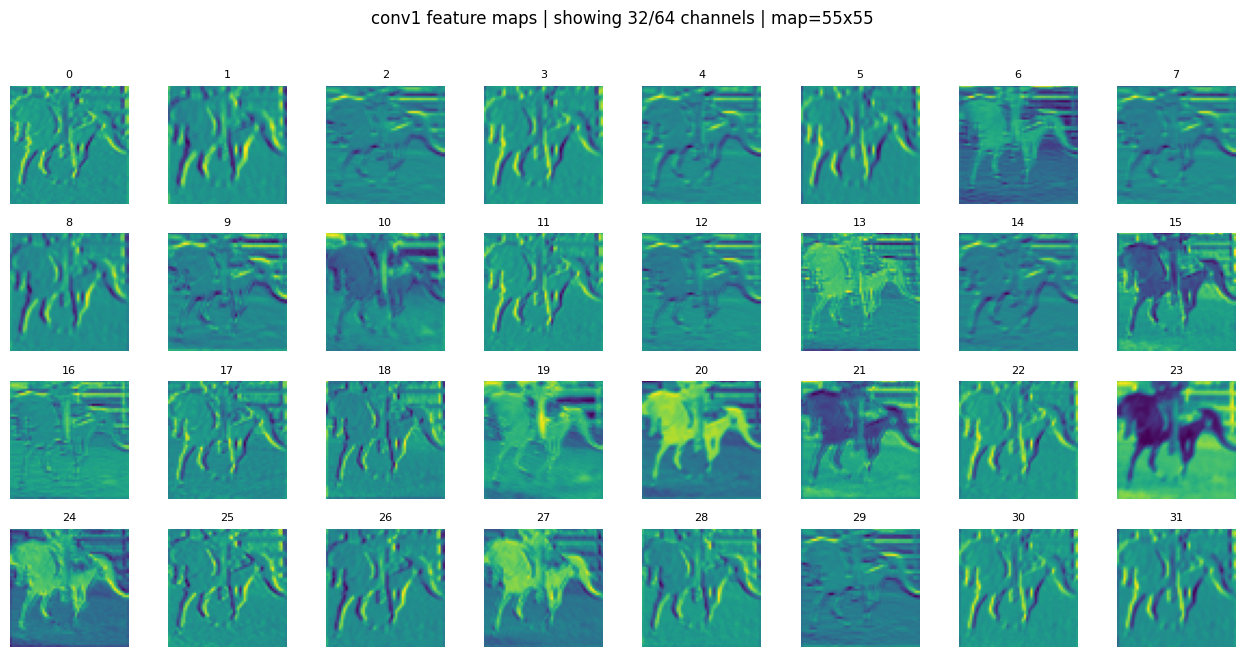

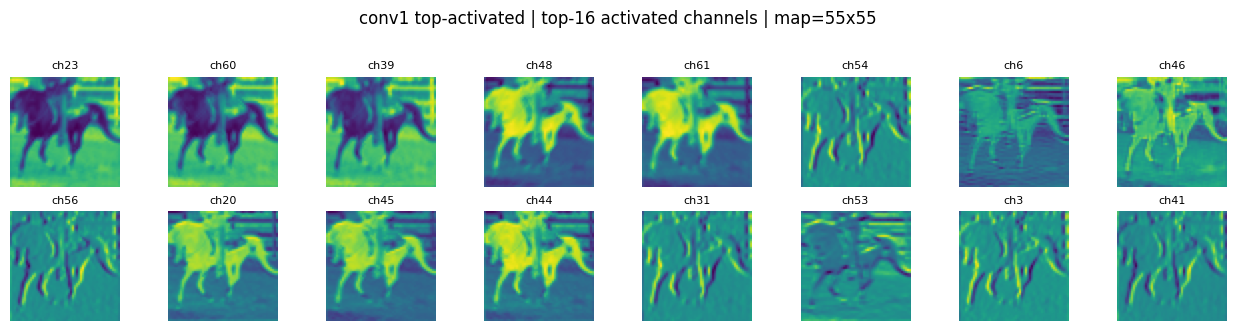

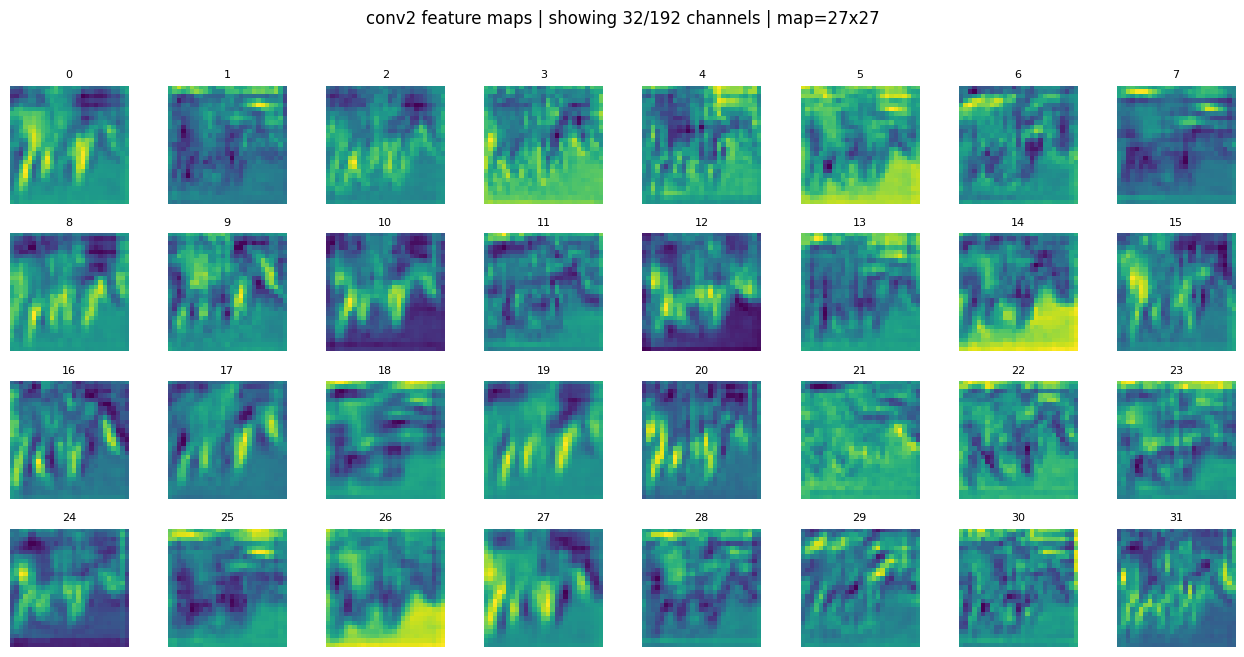

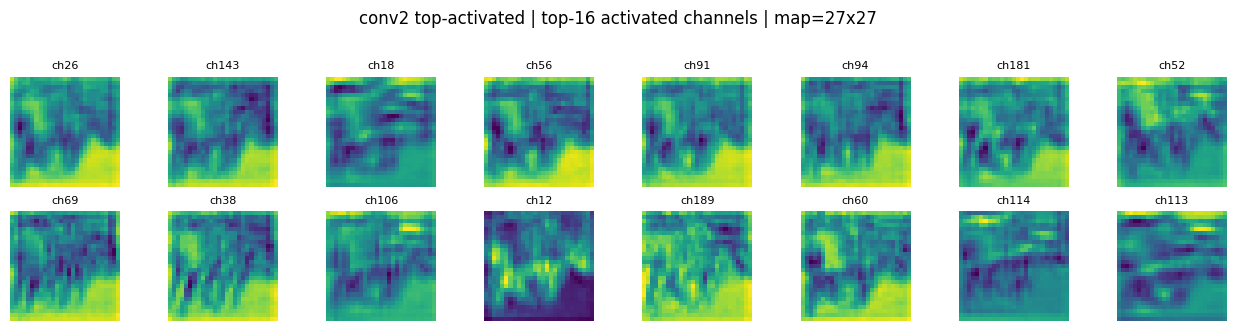

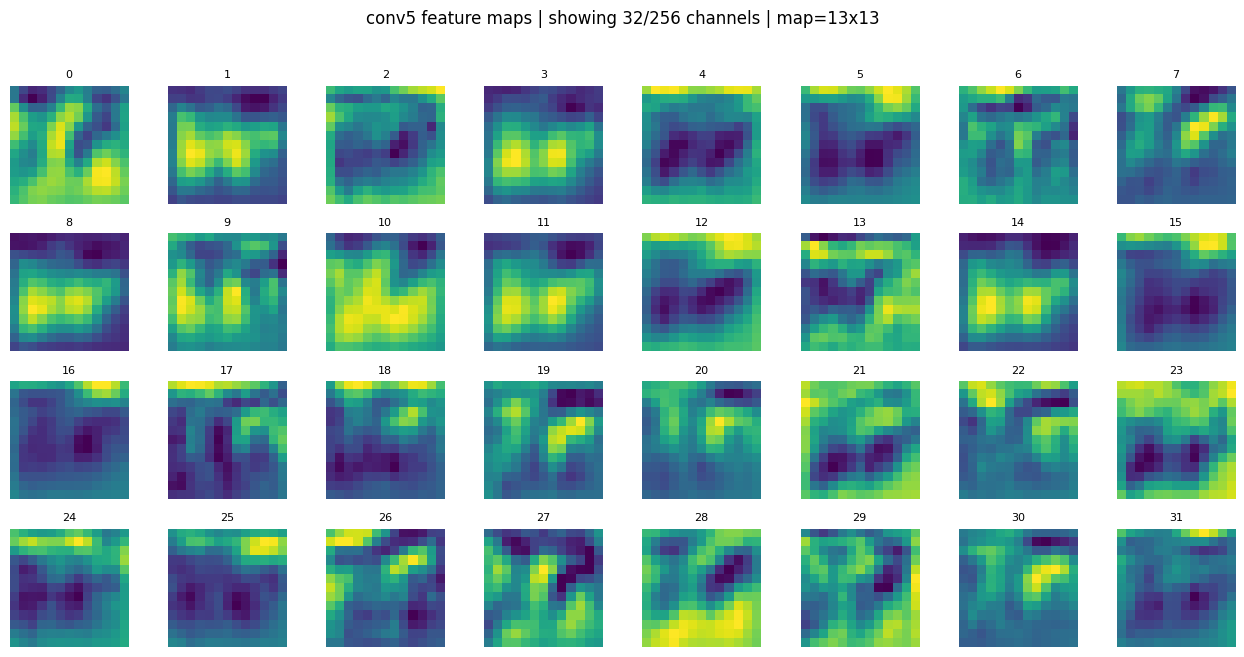

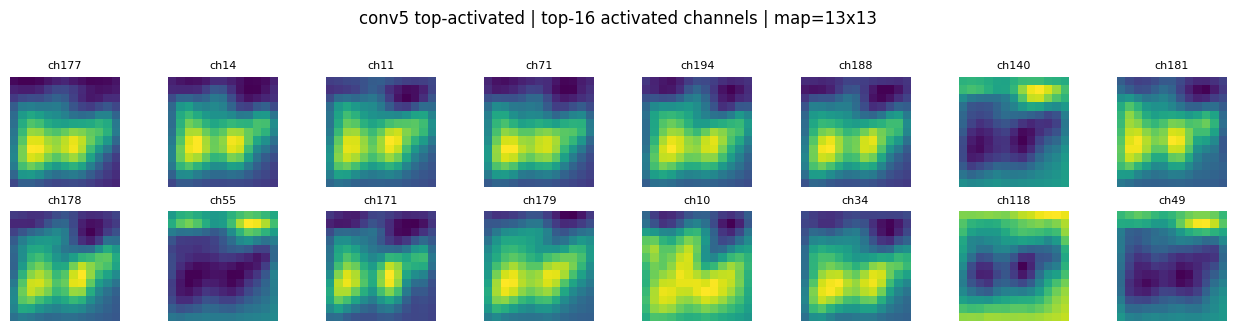

✅ Feature visualization complete


In [21]:
# Step 19: Visualize feature maps from captured activations

import numpy as np
import matplotlib.pyplot as plt

assert "acts" in globals() and len(acts) > 0, "No activations found. Run Step 18 first."

# --- helper: show input image (denormalized) ---
plt.figure(figsize=(4,4))
plt.imshow(denorm(x_img).permute(1,2,0))
plt.title(f"Input | true={train_ds.classes[int(y_lbl)]} | pred={train_ds.classes[pred]}")
plt.axis("off")
plt.show()

def show_feature_grid(feat, title, max_channels=32, ncols=8):
    """
    feat: Tensor (1,C,H,W) on CPU
    Shows up to max_channels feature maps as a grid.
    """
    feat = feat[0]  # (C,H,W)
    C, H, W = feat.shape
    n = min(C, max_channels)
    nrows = int(np.ceil(n / ncols))

    plt.figure(figsize=(1.6*ncols, 1.6*nrows))
    for i in range(n):
        ax = plt.subplot(nrows, ncols, i+1)
        fm = feat[i].numpy()

        # normalize per-channel for visualization
        fm = (fm - fm.min()) / (fm.max() - fm.min() + 1e-8)

        ax.imshow(fm)
        ax.set_title(str(i), fontsize=8)
        ax.axis("off")

    plt.suptitle(f"{title} | showing {n}/{C} channels | map={H}x{W}", y=1.02)
    plt.tight_layout()
    plt.show()

def show_top_activated(feat, title, topk=16, ncols=8):
    """
    Picks channels with highest mean activation magnitude and visualizes them.
    """
    feat = feat[0]  # (C,H,W)
    C, H, W = feat.shape
    scores = feat.abs().mean(dim=(1,2))  # (C,)
    top_idx = torch.topk(scores, k=min(topk, C)).indices.cpu().tolist()

    n = len(top_idx)
    nrows = int(np.ceil(n / ncols))

    plt.figure(figsize=(1.6*ncols, 1.6*nrows))
    for j, ch in enumerate(top_idx):
        ax = plt.subplot(nrows, ncols, j+1)
        fm = feat[ch].numpy()
        fm = (fm - fm.min()) / (fm.max() - fm.min() + 1e-8)
        ax.imshow(fm)
        ax.set_title(f"ch{ch}", fontsize=8)
        ax.axis("off")

    plt.suptitle(f"{title} | top-{n} activated channels | map={H}x{W}", y=1.02)
    plt.tight_layout()
    plt.show()

# --- choose layers to visualize ---
layers_to_show = ["conv1", "conv2", "conv5"]   # change as you like: pool1, conv3, conv4, pool3

for lname in layers_to_show:
    if lname in acts:
        show_feature_grid(acts[lname], title=f"{lname} feature maps", max_channels=32, ncols=8)
        show_top_activated(acts[lname], title=f"{lname} top-activated", topk=16, ncols=8)
    else:
        print("Layer not found in acts:", lname)

print("✅ Feature visualization complete")

# When you're fully done with hooks, remove them:
# for h in handles: h.remove()

# Step 20A — Visualize Conv1 filters (what AlexNet learns first)

Conv1 weight shape: (64, 3, 11, 11)


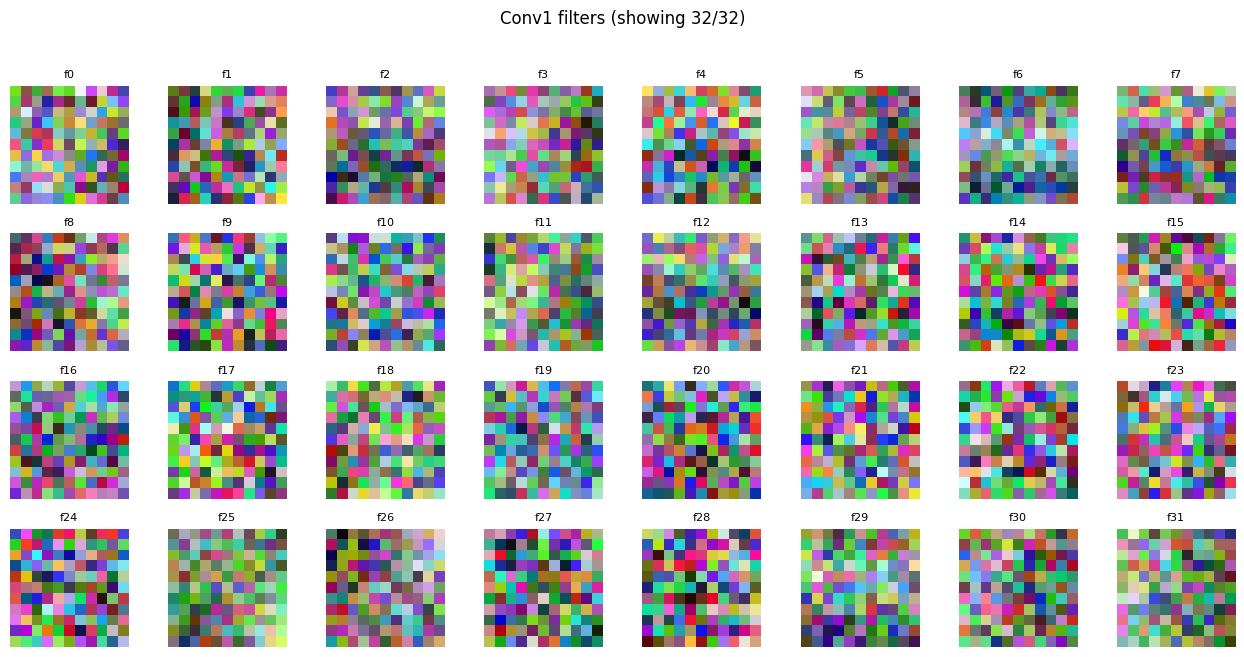

In [22]:
# Step 20A: Visualize Conv1 filters (weights)

import numpy as np
import matplotlib.pyplot as plt
import torch

conv1 = model.features[0]
W = conv1.weight.detach().cpu()   # (64, 3, 11, 11)

print("Conv1 weight shape:", tuple(W.shape))

def show_conv1_filters(W, n_show=32, ncols=8):
    """
    W: (out_channels, in_channels=3, kH, kW)
    Shows n_show filters as RGB images.
    """
    W = W[:n_show]  # (N,3,11,11)
    n = W.shape[0]
    nrows = int(np.ceil(n / ncols))

    plt.figure(figsize=(1.6*ncols, 1.6*nrows))
    for i in range(n):
        w = W[i].clone()  # (3,11,11)

        # Normalize this filter for visualization to [0,1]
        w = w - w.min()
        w = w / (w.max() + 1e-8)

        img = w.permute(1, 2, 0).numpy()  # HWC
        ax = plt.subplot(nrows, ncols, i+1)
        ax.imshow(img)
        ax.set_title(f"f{i}", fontsize=8)
        ax.axis("off")

    plt.suptitle(f"Conv1 filters (showing {n_show}/{W.shape[0]})", y=1.02)
    plt.tight_layout()
    plt.show()

show_conv1_filters(W, n_show=32, ncols=8)


✅ Grad-CAM ready for test_ds[0] | true=horse | pred=horse


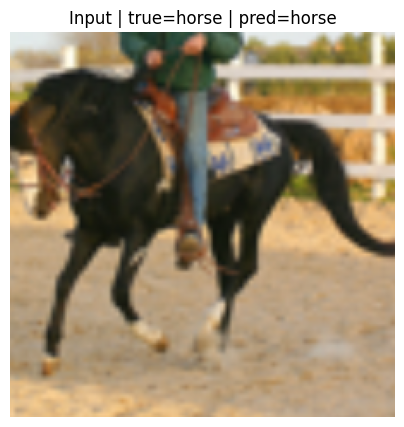

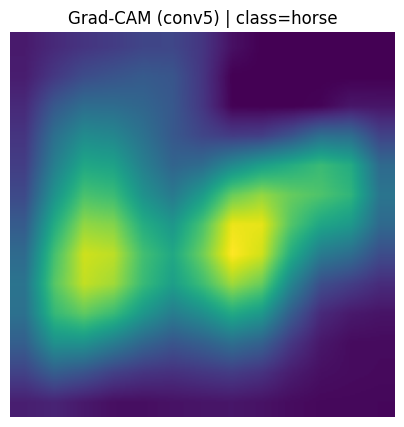

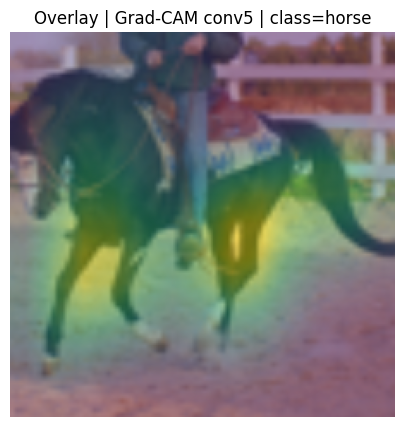

In [23]:
# Step 20B (Fixed): Grad-CAM (Conv5) using tensor gradient hook (safe with inplace ReLU)

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

target_layer = model.features[10]  # Conv5 in our AlexNet

gc = {"acts": None, "grads": None}

def fwd_hook(module, inp, out):
    # Save a CLONE so later in-place ReLU doesn't mutate what we visualize
    gc["acts"] = out.clone()
    # Capture gradients w.r.t. the Conv5 output tensor
    out.register_hook(lambda grad: gc.__setitem__("grads", grad))

handle = target_layer.register_forward_hook(fwd_hook)

# Choose an image (reuse idx from Step 18 if present)
idx_cam = idx if "idx" in globals() else 0
x_img_cam, y_lbl_cam = test_ds[idx_cam]
x_in_cam = x_img_cam.unsqueeze(0).to(device)

model.eval()
model.zero_grad(set_to_none=True)

# Forward with gradients enabled (NO torch.no_grad here)
logits = model(x_in_cam)
pred_class = int(logits.argmax(dim=1).detach().cpu())

# Explain predicted class (or set to true label if you prefer)
class_to_explain = pred_class
score = logits[0, class_to_explain]
score.backward()

# Remove hook
handle.remove()

acts = gc["acts"]
grads = gc["grads"]
assert acts is not None and grads is not None, "Grad-CAM failed to capture activations/gradients."

# Grad-CAM computation
weights = grads.mean(dim=(2, 3), keepdim=True)          # (1,C,1,1)
cam = (weights * acts).sum(dim=1, keepdim=True)         # (1,1,H,W)
cam = F.relu(cam)

# Upsample to input size
cam_up = F.interpolate(cam, size=(CFG["img_size"], CFG["img_size"]),
                       mode="bilinear", align_corners=False)
cam_up = cam_up[0, 0].detach().cpu().numpy()
cam_up = (cam_up - cam_up.min()) / (cam_up.max() - cam_up.min() + 1e-8)

# Prepare input image for display (denormalized)
img_vis = denorm(x_img_cam).permute(1, 2, 0).numpy()

print(f"✅ Grad-CAM ready for test_ds[{idx_cam}] | true={train_ds.classes[int(y_lbl_cam)]} | pred={train_ds.classes[pred_class]}")

# Plot: input, CAM, overlay
plt.figure(figsize=(5,5))
plt.imshow(img_vis)
plt.title(f"Input | true={train_ds.classes[int(y_lbl_cam)]} | pred={train_ds.classes[pred_class]}")
plt.axis("off")
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(cam_up)
plt.title(f"Grad-CAM (conv5) | class={train_ds.classes[class_to_explain]}")
plt.axis("off")
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(img_vis)
plt.imshow(cam_up, alpha=0.45)   # overlay
plt.title(f"Overlay | Grad-CAM conv5 | class={train_ds.classes[class_to_explain]}")
plt.axis("off")
plt.show()


In [24]:
# Step 21: Remove any remaining hooks safely

import torch.nn as nn

# Remove Step-18 forward hooks (if you used "handles")
if "handles" in globals() and handles is not None:
    for h in handles:
        try: h.remove()
        except: pass
    handles = []
    print("✅ Removed Step-18 hooks")

# Clear any stray hooks (extra safety)
for m in model.modules():
    if hasattr(m, "_forward_hooks"): m._forward_hooks.clear()
    if hasattr(m, "_forward_pre_hooks"): m._forward_pre_hooks.clear()
    if hasattr(m, "_backward_hooks"): m._backward_hooks.clear()
    if hasattr(m, "_backward_pre_hooks"): m._backward_pre_hooks.clear()

print("✅ Cleared all module hook dictionaries")

✅ Removed Step-18 hooks
✅ Cleared all module hook dictionaries


# Step 22 — Single-image inference (Predict one image class)

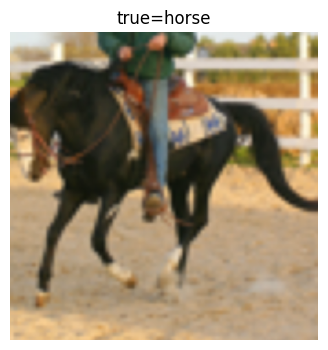

Predictions for test_ds[0]:
       horse  prob=0.8443
         dog  prob=0.0626
        deer  prob=0.0540
      monkey  prob=0.0255
         cat  prob=0.0096
✅ predicted: horse


In [25]:
# Step 22: Single-image inference with top-k

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

@torch.no_grad()
def predict_one(idx=0, topk=5):
    model.eval()
    x_img, y_lbl = test_ds[idx]
    x_in = x_img.unsqueeze(0).to(device)

    logits = model(x_in)
    probs = F.softmax(logits, dim=1)[0].detach().cpu()
    top_p, top_i = torch.topk(probs, k=topk)

    # display
    plt.figure(figsize=(4,4))
    plt.imshow(denorm(x_img).permute(1,2,0))
    plt.axis("off")
    plt.title(f"true={train_ds.classes[int(y_lbl)]}")
    plt.show()

    print(f"Predictions for test_ds[{idx}]:")
    for p, i in zip(top_p.tolist(), top_i.tolist()):
        print(f"  {train_ds.classes[i]:>10s}  prob={p:.4f}")

    return int(y_lbl), int(top_i[0])

true_lbl, pred_lbl = predict_one(idx=0, topk=5)
print("✅ predicted:", train_ds.classes[pred_lbl])


In [26]:
# Step 23: Batch inference (first test batch) + quick summary

import torch
import torch.nn.functional as F

@torch.no_grad()
def predict_batch(n_show=16):
    model.eval()
    xb, yb = next(iter(test_loader))
    xb = xb.to(device, non_blocking=True)

    logits = model(xb)
    pred = logits.argmax(dim=1).detach().cpu()

    print("First", n_show, "samples:")
    for i in range(n_show):
        t = int(yb[i])
        p = int(pred[i])
        print(f"{i:02d}: true={train_ds.classes[t]:>10s} | pred={train_ds.classes[p]:>10s}")

predict_batch(n_show=16)


First 16 samples:
00: true=     horse | pred=     horse
01: true=    monkey | pred=      deer
02: true=       dog | pred=      bird
03: true=  airplane | pred=      ship
04: true=       cat | pred=    monkey
05: true=      bird | pred=    monkey
06: true=      bird | pred=       dog
07: true=      bird | pred=      bird
08: true=      deer | pred=       dog
09: true=      deer | pred=  airplane
10: true=  airplane | pred=  airplane
11: true=  airplane | pred=  airplane
12: true=      deer | pred=      deer
13: true=  airplane | pred=  airplane
14: true=      bird | pred=       cat
15: true=       dog | pred=    monkey
